Using DISCOS dataset to predict the mission from which a debris has originated. Target is object class (debris type), features are the physical characteristics of the debris.
- name: jayneknight
- token: IjBhN2MyNWI3LWFiM2QtNDQ2NC1iZWJlLTc4MzI1MWYxMGM5NSI.FSM7I5rsEEDaRlOF3vhdM_Vum9w
- website: https://discosweb.esoc.esa.int

### First we import the data from DISCOS
We're leaving out datapoints that have no associated mission

In [1]:
# Importing dataset

from pprint import pprint
import requests

URL = 'https://discosweb.esoc.esa.int'
token = 'IjI1MGIzOTM3LWQyODgtNGI0Yy1hMWZjLWVmOTMyYzg5ZjkxZSI.3LEu6HW4_k2T_sXkgOtG_TyhFdY'

data_list = []
meta_list = []
for n in range(0,29):
    for i in range(1+(20*n),21+(20*n)):
        response = requests.get(
            f'{URL}/api/objects',
            headers={
                'Authorization': f'Bearer {token}',
                'DiscosWeb-Api-Version': '2',
            },
            params={
                'filter': "ne(name,None)&ne(objectClass,Unknown)&iexcludes(name,Snapshot)",
                'sort': 'cosparId',
                'page[number]': i,
                'page[size]': 100,
            },
        )

        doc = response.json()

        if response.status_code == 200:
            data_list.append(doc['data'])
            meta_list.append(doc['meta'])
        else:
            # print('i =', i)
            # pprint(doc['errors'][0]['title'])
            break

            
print('type:', type(data_list),'  length:', len(data_list))
# print('type:', type(data_list[19]),'  length:', len(data_list[19]))
# print('type:', type(data_list[19][0]))
# print('meta:', meta_list[18], 'length', len(meta_list))

type: <class 'list'>   length: 20


From what I can tell, the data is a dictionary whose first key is 'data'. The value of this key is a list, which contains a dictionary for each entry. We're interested in the 'attributes' key for the data.

In [2]:
debris_list = []
for i in range(0,len(data_list)):
    for j in range(0,len(data_list[0])):
        # print('\n', i,j)
        # print(data_list[i][j]['attributes'])
        debris_list.append(data_list[i][j]['attributes'])
        

In [3]:
import pandas as pd

df = pd.DataFrame(debris_list)
df = df.drop(labels=['vimpelId', 'depth', 'satno', 'cosparId'], axis=1)
df

,name,xSectAvg,shape,width,xSectMax,height,diameter,xSectMin,mass,span,objectClass
0,Sputnik (8K71PS) Blok-A,59.831632,Cyl,NaN,72.993346,28.00,2.60,5.309292,3964.32,28.00,Rocket Body
1,Sputnik 1,0.264200,Sphere,0.58,0.264200,0.58,NaN,0.264200,82.85,0.58,Payload
2,Sputnik 2,1.963495,Cone + Cyl,NaN,2.148686,2.00,1.00,0.785398,503.77,2.00,Payload
3,Explorer 1,0.247989,Cyl,NaN,0.305012,2.03,0.15,0.017671,13.88,2.03,Payload
4,Grand Central (ALB) (Vanguard),1.017091,Cyl,NaN,1.118305,1.50,0.70,0.384845,22.79,1.50,Rocket Body
...,...,...,...,...,...,...,...,...,...,...,...
1995,Apollo Model 4,16.693638,Cone + Cyl,NaN,18.139106,3.50,3.90,11.945906,5173.00,3.90,Payload
1996,Cosmos-67,11.686725,Sphere + Cyl + 1 DCone,NaN,12.824415,5.00,2.40,4.523893,5650.00,6.50,Payload
1997,Blok-I (Soyuz SL-4 (A-2)),22.416677,Cyl,NaN,25.614099,9.40,2.66,5.557163,3000.00,9.40,Rocket Body
1998,Voskhod operational debris,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rocket Mission Related Object


### Preprocesing the data.
Note: using the names at all is an artifact from when 'name' was the target, the column is not included in the CNN training or testing, but it was in the original filtering process.

In [4]:
# changing string values into numbers
objCl_cklist = []
shape_cklist = []

for i in range(0, len(df['name'])):
    objCl = df.loc[i, ('objectClass')]
    shape = df.loc[i, ('shape')]
        
    if objCl in objCl_cklist:
        df.loc[i, ('objectClass')] = objCl_cklist.index(objCl)
    elif objCl not in objCl_cklist:
        objCl_cklist.append(objCl)
        df.loc[i, ('objectClass')] = objCl_cklist.index(objCl)
    
    if shape in shape_cklist:
        df.loc[i, ('shape')] = shape_cklist.index(shape)
    elif shape not in shape_cklist:
        shape_cklist.append(shape)
        df.loc[i, ('shape')] = shape_cklist.index(shape)
        
df

,name,xSectAvg,shape,width,xSectMax,height,diameter,xSectMin,mass,span,objectClass
0,Sputnik (8K71PS) Blok-A,59.831632,0,NaN,72.993346,28.00,2.60,5.309292,3964.32,28.00,0
1,Sputnik 1,0.264200,1,0.58,0.264200,0.58,NaN,0.264200,82.85,0.58,1
2,Sputnik 2,1.963495,2,NaN,2.148686,2.00,1.00,0.785398,503.77,2.00,1
3,Explorer 1,0.247989,0,NaN,0.305012,2.03,0.15,0.017671,13.88,2.03,1
4,Grand Central (ALB) (Vanguard),1.017091,0,NaN,1.118305,1.50,0.70,0.384845,22.79,1.50,0
...,...,...,...,...,...,...,...,...,...,...,...
1995,Apollo Model 4,16.693638,2,NaN,18.139106,3.50,3.90,11.945906,5173.00,3.90,1
1996,Cosmos-67,11.686725,23,NaN,12.824415,5.00,2.40,4.523893,5650.00,6.50,1
1997,Blok-I (Soyuz SL-4 (A-2)),22.416677,0,NaN,25.614099,9.40,2.66,5.557163,3000.00,9.40,0
1998,Voskhod operational debris,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


In [5]:
print('num obj classes:', len(objCl_cklist), '\nclasses:', objCl_cklist)

num obj classes: 8 
classes: ['Rocket Body', 'Payload', 'Rocket Mission Related Object', 'Payload Mission Related Object', 'Payload Fragmentation Debris', 'Rocket Fragmentation Debris', 'Payload Debris', 'Rocket Debris']


In [6]:
print('num shapes:', len(shape_cklist), '\nshapes:', shape_cklist)

num shapes: 53 
shapes: ['Cyl', 'Sphere', 'Cone + Cyl', None, 'Cone', 'Sphere + 4 Pan', 'Sphere + Cyl', 'Ell', 'Cone + Cone', 'Double Cone', 'Irr', 'Cyl + Cone', 'Oct Cyl + 4 Pan', 'Cone + 2 Pan', 'Cyl + 1 Nozzle', 'Cyl + Ell', 'Hex Poly', 'Cyl + 4 Pan', 'Hex Cyl', 'Oct Cyl', 'Cyl + 1 Frust', 'Cyl + Irr', 'Polyhedral Cyl', 'Sphere + Cyl + 1 DCone', 'Sphere + 1 Ant', 'Cyl + 2 Pan', 'Trap Box', 'Box', 'Oct Cyl + 4 Pan + 1 Rod', 'Box + 1 Cable', 'Poly', 'Trunc Cone', 'Oct Cyl + 1 Rod', 'Step Cyl + 2 Pan + 1 Dish', 'Cyl + 2 Nozzle', 'Oct Cyl + Cyl + 1 Rod', 'Half Cyl + Cone', 'Cyl + 6 Pan', 'Flared Cyl + 2 Ant', 'Oct Cyl + 1 Truss + 2 Pan', 'Cyl + 2 Pan + 1 Rod', 'Double Cone + 6 Rod', 'Box + 2 Pan + 2 Rod', 'Oct Cyl + 2 Pan + 2 Rod', 'Oct Cyl + 4 Pan + 2 Rod', 'Oct Cyl + 1 Ant + 4 Pan', 'Cyl + 1 Dish', 'Cyl + 1 Sail + 2 Ant', 'Sphere + 3 Ant', 'Box + 4 Ant', 'Sphere + 12 Rod', 'Oct Cyl + 4 Pan + 4 Rod', 'Sphere + Cone']


### Here's how the data breaks down by 'objectClass', I can remove problem points to fix some of the NaN issues.
- 7 : 1pt 
- 6 : NaN issues, 14pts 
- 5 : NaN issues, 480pts 
- 4 : NaN issues, 348pts 
- 3 : Some Useable, 282pts  
- 2 : Some Useable, 206pts  
- 1 : Most Useable, 390pts  
- 0 : Most Useable, 279pts  

Datapoints with 'objectClass' 4/5/6/7 will be removed.

In [7]:
# removing data with more than half empty cells
import numpy as np
reduce_df = df

for i in range(0, len(reduce_df['xSectAvg'])):
    if df.loc[i, ('objectClass')] in range(4,8):
        reduce_df = reduce_df.drop(labels=[i], axis=0)
            
    else:
        nan_ck = 0
        for val in df.loc[i,:]:
            if type(val) != str: 
                if np.isnan(val): nan_ck += 1
        
        if nan_ck >= 6:
            reduce_df = reduce_df.drop(labels=[i], axis=0)

# re-number the data now that removing portion is done
reduce_df = reduce_df.reset_index(drop=True)
reduce_df

,name,xSectAvg,shape,width,xSectMax,height,diameter,xSectMin,mass,span,objectClass
0,Sputnik (8K71PS) Blok-A,59.831632,0,NaN,72.993346,28.00,2.60,5.309292,3964.32,28.00,0
1,Sputnik 1,0.264200,1,0.58,0.264200,0.58,NaN,0.264200,82.85,0.58,1
2,Sputnik 2,1.963495,2,NaN,2.148686,2.00,1.00,0.785398,503.77,2.00,1
3,Explorer 1,0.247989,0,NaN,0.305012,2.03,0.15,0.017671,13.88,2.03,1
4,Grand Central (ALB) (Vanguard),1.017091,0,NaN,1.118305,1.50,0.70,0.384845,22.79,1.50,0
...,...,...,...,...,...,...,...,...,...,...,...
629,Altair 3 (Thor-Altair),0.687223,0,NaN,0.775276,1.50,0.50,0.196350,23.79,1.50,0
630,Pegasus 2,23.925445,25,NaN,53.682726,5.00,2.00,3.141593,10300.00,29.00,1
631,Apollo Model 4,16.693638,2,NaN,18.139106,3.50,3.90,11.945906,5173.00,3.90,1
632,Cosmos-67,11.686725,23,NaN,12.824415,5.00,2.40,4.523893,5650.00,6.50,1


In [8]:
# replace NaN values with 0
import numpy as np

zero_df = reduce_df

for i in range(0, len(reduce_df['xSectAvg'])):

    if np.isnan(reduce_df.loc[i, ('xSectAvg')]):
        zero_df.loc[i, ('xSectAvg')] = 0
        
    if np.isnan(reduce_df.loc[i, ('width')]):
        zero_df.loc[i, ('width')] = 0
    
    if np.isnan(reduce_df.loc[i, ('xSectMax')]):
        zero_df.loc[i, ('xSectMax')] = 0
        
    if np.isnan(reduce_df.loc[i, ('height')]):
        zero_df.loc[i, ('height')] = 0
        
    if np.isnan(reduce_df.loc[i, ('diameter')]):
        zero_df.loc[i, ('diameter')] = 0
        
    if np.isnan(reduce_df.loc[i, ('xSectMin')]):
        zero_df.loc[i, ('xSectMin')] = 0
        
    if np.isnan(reduce_df.loc[i, ('xSectMax')]):
        zero_df.loc[i, ('xSectMax')] = 0
    
    if np.isnan(reduce_df.loc[i, ('mass')]):
        zero_df.loc[i, ('mass')] = 0
        
    if np.isnan(reduce_df.loc[i, ('span')]):
        zero_df.loc[i, ('span')] = 0

good_data = zero_df.drop(labels=['width'], axis=1)
good_data

,name,xSectAvg,shape,xSectMax,height,diameter,xSectMin,mass,span,objectClass
0,Sputnik (8K71PS) Blok-A,59.831632,0,72.993346,28.00,2.60,5.309292,3964.32,28.00,0
1,Sputnik 1,0.264200,1,0.264200,0.58,0.00,0.264200,82.85,0.58,1
2,Sputnik 2,1.963495,2,2.148686,2.00,1.00,0.785398,503.77,2.00,1
3,Explorer 1,0.247989,0,0.305012,2.03,0.15,0.017671,13.88,2.03,1
4,Grand Central (ALB) (Vanguard),1.017091,0,1.118305,1.50,0.70,0.384845,22.79,1.50,0
...,...,...,...,...,...,...,...,...,...,...
629,Altair 3 (Thor-Altair),0.687223,0,0.775276,1.50,0.50,0.196350,23.79,1.50,0
630,Pegasus 2,23.925445,25,53.682726,5.00,2.00,3.141593,10300.00,29.00,1
631,Apollo Model 4,16.693638,2,18.139106,3.50,3.90,11.945906,5173.00,3.90,1
632,Cosmos-67,11.686725,23,12.824415,5.00,2.40,4.523893,5650.00,6.50,1


In [9]:
# names were changed to numbers last to avoid labeling target data that would be filtered
# out, this step isn't necessary when debType (formerly objectClass) is the target

name_cklist = []

for i in range(0, len(good_data['name'])):
    name = good_data.loc[i, ('name')]
    
    if name in name_cklist:
        good_data.loc[i, ('name')] = name_cklist.index(name)
    elif name not in name_cklist:
        name_cklist.append(name)
        good_data.loc[i, ('name')] = name_cklist.index(name)

good_data = good_data.rename(columns={"name": "target", "objectClass": "debType"})
good_data

,target,xSectAvg,shape,xSectMax,height,diameter,xSectMin,mass,span,debType
0,0,59.831632,0,72.993346,28.00,2.60,5.309292,3964.32,28.00,0
1,1,0.264200,1,0.264200,0.58,0.00,0.264200,82.85,0.58,1
2,2,1.963495,2,2.148686,2.00,1.00,0.785398,503.77,2.00,1
3,3,0.247989,0,0.305012,2.03,0.15,0.017671,13.88,2.03,1
4,4,1.017091,0,1.118305,1.50,0.70,0.384845,22.79,1.50,0
...,...,...,...,...,...,...,...,...,...,...
629,426,0.687223,0,0.775276,1.50,0.50,0.196350,23.79,1.50,0
630,451,23.925445,25,53.682726,5.00,2.00,3.141593,10300.00,29.00,1
631,452,16.693638,2,18.139106,3.50,3.90,11.945906,5173.00,3.90,1
632,453,11.686725,23,12.824415,5.00,2.40,4.523893,5650.00,6.50,1


### Visualizing the data

In [10]:
import seaborn as sns

sns.pairplot(good_data, x_vars= good_data.drop(labels=['target', 'debType', 'xSectAvg', 'xSectMin', 'xSectMax'],axis=1), 
             y_vars=good_data.drop(labels=['target', 'debType','xSectAvg', 'xSectMin', 'xSectMax'],axis=1), 
             hue='debType')


### Create the CNN
Target is debType, ie we figure out what part of the spacecraft it was based on the rest of the features.

In [11]:
# Split into test and train data
from sklearn.model_selection import train_test_split

X = np.asarray(good_data.drop(labels=['debType', 'target'], axis=1)).astype('float32')
y = np.asarray(good_data['debType']).astype('float32')

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.30,
    train_size = 0.70,
    random_state = 312,
    shuffle = True)

print(X.shape, y.shape)

(634, 8) (634,)


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf

model = Sequential()
model.add(Dense(16, activation='sigmoid', input_shape=(8,)))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)
model.compile(optimizer=opt, loss=mse, metrics=['accuracy'])
model.summary()

#'categorical_crossentropy'
#'relu'
#'softmax'

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                144       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 4)                 36        
                                                                 
 dense_3 (Dense)             (None, 2)                 10        
                                                                 
 dense_4 (Dense)             (None, 1)                 3         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(X_train, y_train, 
    epochs = 50, 
    batch_size = 110, 
    validation_split = 0.3,
    verbose=False)

In [14]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

6/6 [==============================] - 0s 2ms/step - loss: 16.4669 - accuracy: 0.5759
Test accuracy: 0.5759162306785583


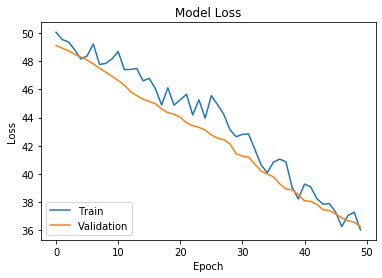

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower left')
plt.show()

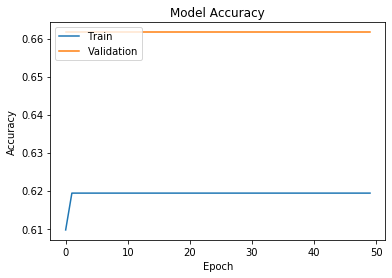

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Predicted vs Actual Data

In [39]:
preds = model.predict(X_test)
print(np.transpose(preds[0:10]))

6/6 [==============================] - 0s 1ms/step
[[0.66142076 0.7026771  0.5770414  0.69999015 0.5659399  0.69430214
  0.6911114  0.7619915  0.5698234  0.6539791 ]]


In [19]:
pred_data = pd.DataFrame(X_test)
pred_data[8] = y_test
pred_data['pred'] = model.predict(X_test)
pred_data

6/6 [==============================] - 0s 1ms/step


,0,1,2,3,4,5,6,7,8,pred
0,0.196300,1.0,0.196300,0.50,0.0,0.196300,48.000000,0.50,1.0,0.661421
1,0.424100,4.0,0.636200,0.80,0.0,0.270000,148.660004,0.80,3.0,0.702677
2,10.414380,0.0,11.216192,3.80,2.6,5.309291,1427.160034,3.80,0.0,0.577041
3,0.424100,4.0,0.636200,0.80,0.0,0.270000,138.750000,0.80,3.0,0.699990
4,59.831631,0.0,72.993347,28.00,2.6,5.309291,3964.320068,28.00,0.0,0.565940
...,...,...,...,...,...,...,...,...,...,...
186,4.398300,13.0,7.640900,3.97,0.0,1.805300,303.269989,5.18,1.0,0.619755
187,11.045839,0.0,12.941146,7.99,1.6,2.010619,840.000000,7.99,0.0,0.566284
188,14.646105,0.0,16.404129,6.57,2.4,4.523893,1434.000000,6.57,0.0,0.566234
189,0.675000,27.0,0.895489,0.30,0.0,0.270000,126.000000,0.90,1.0,0.687076


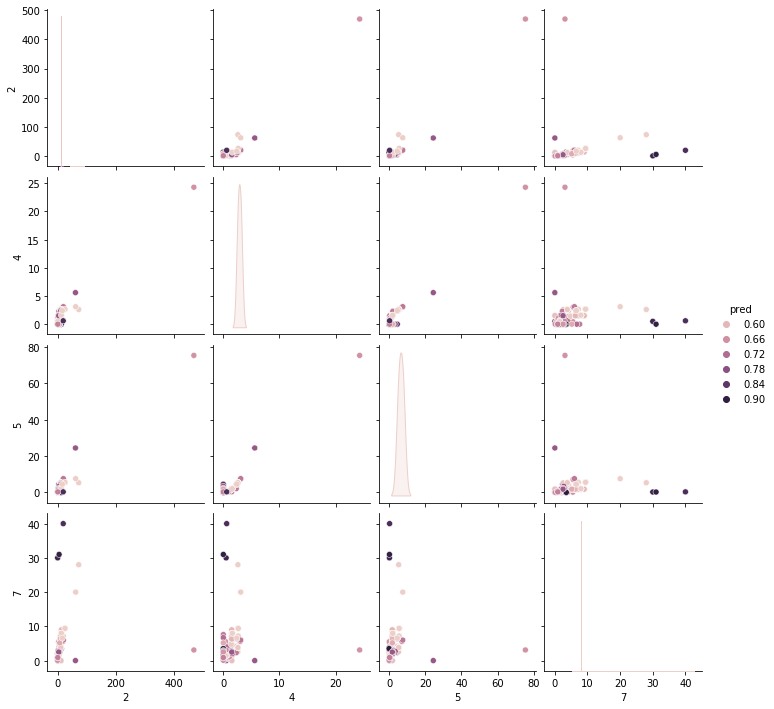

In [20]:
sns.pairplot(pred_data, x_vars= pred_data.drop(labels=[0, 1, 3, 6, 8, 'pred'], axis=1), 
             y_vars=pred_data.drop(labels=[0, 1, 3, 6, 8,'pred'], axis=1), 
             hue='pred')

In [40]:
grouped_pred = preds
for i in range(0, len(grouped_pred)):
    p = preds[i]
    if p <= 0.6:
        grouped_pred[i] = 0
    else:
        grouped_pred[i] = 1

print(np.transpose(grouped_pred))

[[1. 1. 0. 1. 0. 1. 1. 1. 0. 1.]]
[[1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1.
  1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1.
  1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0.
  1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1.
  0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0.
  0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0.
  1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1.
  1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1.]]


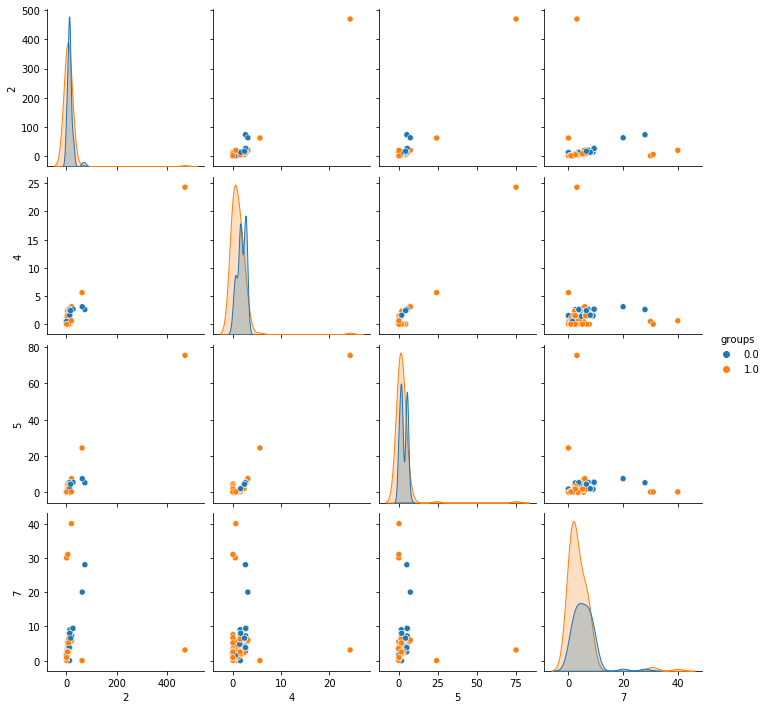

In [41]:
pred_data['groups'] = grouped_pred
pred_data

sns.pairplot(pred_data, x_vars= pred_data.drop(labels=[0, 1, 3, 6, 8, 'pred','groups'], axis=1), 
             y_vars=pred_data.drop(labels=[0, 1, 3, 6, 8,'pred','groups'], axis=1), 
             hue='groups')

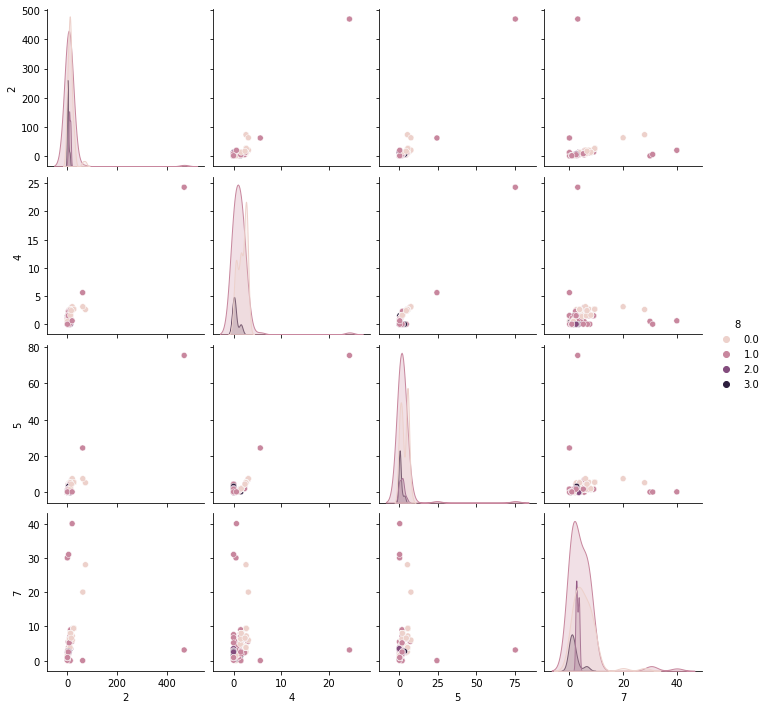

In [21]:
sns.pairplot(pred_data, x_vars= pred_data.drop(labels=[0, 1, 3, 6, 8, 'pred'], axis=1), 
             y_vars=pred_data.drop(labels=[0, 1, 3, 6, 8,'pred'], axis=1), 
             hue=8)